## This file allows you to make predictions on specific cell types or additionally also allows you to select files from the loaded set which have a specific keyword in their name
## This file requires you to have models saved at checkpoints to be able to do inference
## At the end of this file, predictions have been made on the validation set

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import defaultdict

In [ ]:
model_dir = "results/density_models"
# model_dir = "results/models_uncertainty" # For uncertainty
# model_dir = "results/passive_learning_partial_training_aws_reproducible/models" # For passive

# Helper Functions and Class

In [23]:
# Class to load the dataset
class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, keyword=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Load and filter filenames by keyword (if provided)
        image_filenames = sorted(os.listdir(image_dir))
        mask_filenames = sorted(os.listdir(mask_dir))

        if keyword:
            self.image_filenames = [f for f in image_filenames if keyword in f]
            self.mask_filenames = [f for f in mask_filenames if keyword in f]
        else:
            self.image_filenames = image_filenames
            self.mask_filenames = mask_filenames

        assert len(self.image_filenames) == len(self.mask_filenames), \
            "Mismatch between image and mask counts after filtering"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = image.astype('float32') / 255.0
        mask = (mask > 0).astype('float32')

        image = torch.tensor(image).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        image = pad_to_multiple(image)
        mask = pad_to_multiple(mask)

        return image, mask, self.image_filenames[idx]

In [24]:
# Required to ensure input is in the correct format to the model
def pad_to_multiple(x, multiple=32):
    h, w = x.shape[-2], x.shape[-1]
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    return F.pad(x, (0, pad_w, 0, pad_h))
# To view predictions in original dimensions
def unpad_to_shape(x, original_h, original_w):
    return x[..., :original_h, :original_w]

In [25]:
# Helper Function to show predictions generated by the model along with ground truth mask and actual image
def show_prediction(model, img, mask, results_dir, filename, save=True):
    # Prediction mode of model
    model.eval()
    # No learning
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_bin = (pred > 0.5).float().squeeze().cpu().numpy()
    # Original dimensions for all to view
    pred_unpadded = unpad_to_shape(pred_bin, 520, 704)
    img_unpadded = unpad_to_shape(img.squeeze(0), 520, 704)
    mask_unpadded = unpad_to_shape(mask.squeeze(0), 520, 704)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_unpadded, cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(mask_unpadded, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_unpadded, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.tight_layout()
    
    # Functionality to save if required
    if save:
        save_path = f"{results_dir}/{filename}_prediction.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved prediction to {save_path}")
    else:
        plt.show()
    plt.close(fig)

## Model Loading

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Function to load model stored at a path
def load_model_from_checkpoint(path, device='cuda'):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
        activation="sigmoid"
    ).to(device)
    
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

In [7]:
# Get the training dataset to estimate the dataset sizes considered during training
train_ds = CellSegmentationDataset("../data/images_train", "../data/masks_train")

In [26]:
initial_size = 100
increment = 200
max_size = int(0.5 * len(train_ds))
n_simulations = 4

In [27]:
dataset_sizes = list(range(initial_size, max_size + 1, increment))

# Test set by cell type

## Function for all cell types

In [10]:
# This runs predictions from each of the models; model_dir is as defined above
def run_predictions_for_cell_type(cell_type):
    # Get test set
    test_ds = CellSegmentationDataset("../data/images_test", "../data/masks_test", keyword = cell_type)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    test_results = defaultdict(list)
    # Run the passive learning loop but only do inference
    for sim in range(n_simulations):
        for size in sorted(dataset_sizes):
            model_path = os.path.join(model_dir, f"model_sim{sim}_size{size}.pt")
            model = load_model_from_checkpoint(model_path, device=device)

            dice_scores = []

            with torch.no_grad():
                for img, mask, fname in test_loader:
                    img, mask = img.to(device), mask.to(device)

                    pred = model(img)
                    pred_bin = (pred > 0.5).float()
                    
                    # dice score calculation
                    inter = (pred_bin * mask).sum()
                    union = pred_bin.sum() + mask.sum()
                    dice = (2 * inter) / (union + 1e-8)
                    dice_scores.append(dice)
                    
            # Get mean dice score for all the considered images
            avg_dice = np.mean(dice_scores)
            test_results[size].append(avg_dice)
            print(f" Avg Dice for sim {sim}, size {size}: {avg_dice:.4f}")
    test_df = pd.DataFrame(test_results)
    return test_df

In [32]:
# Function to plot the results from the inference and save the csv and plots to files in plot_dir
def plot_res(cell_type, test_df, plot_dir):
    os.makedirs(plot_dir, exist_ok = True)
    test_df.to_csv(f"{plot_dir}/TestDiceScores.csv", index=False)
    # Compute mean and std
    mean_scores = test_df.mean()
    std_scores = test_df.std()

    # Plot
    plt.figure(figsize=(10, 5))
    sizes = dataset_sizes
    plt.plot(sizes, mean_scores, label='Average Test Dice', color='orange', marker='o')
    plt.fill_between(sizes, mean_scores - std_scores, mean_scores + std_scores, color='orange', alpha=0.3)
    plt.xlabel("Training Set Size")
    plt.ylabel("Dice Score")
    plt.title(f"Performance on {cell_type}: Dice Score by Training Set Size")
    plt.grid(True)
    plt.legend()
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/dice_vs_train_size.png")
    plt.show()

In [12]:
# cell_types = ["BT474", "BV2", "Huh7", "MCF7", "SHSY5Y", "SkBr3", "SKOV3"]
cell_types = ["BT474", "BV2", "MCF7", "SHSY5Y"] # interesting cell types from passive learning

In [16]:
# Actual loop run to get predictions for considered model_dir models
test_res = {}
for cell in cell_types:
    print(f"Processing cell type {cell}")
    test_res[cell] = run_predictions_for_cell_type(cell)
    print(f"Finished processing {cell}")

Processing cell type BT474
 Avg Dice for sim 0, size 100: 0.7126
 Avg Dice for sim 0, size 300: 0.8387
 Avg Dice for sim 0, size 500: 0.8751
 Avg Dice for sim 0, size 700: 0.8916
 Avg Dice for sim 0, size 900: 0.8902
 Avg Dice for sim 0, size 1100: 0.8933
 Avg Dice for sim 0, size 1300: 0.8928
 Avg Dice for sim 0, size 1500: 0.8984
 Avg Dice for sim 1, size 100: 0.8241
 Avg Dice for sim 1, size 300: 0.8593
 Avg Dice for sim 1, size 500: 0.8835
 Avg Dice for sim 1, size 700: 0.8898
 Avg Dice for sim 1, size 900: 0.8932
 Avg Dice for sim 1, size 1100: 0.8959
 Avg Dice for sim 1, size 1300: 0.8946
 Avg Dice for sim 1, size 1500: 0.8952
 Avg Dice for sim 2, size 100: 0.8350
 Avg Dice for sim 2, size 300: 0.8645
 Avg Dice for sim 2, size 500: 0.8842
 Avg Dice for sim 2, size 700: 0.8908
 Avg Dice for sim 2, size 900: 0.8917
 Avg Dice for sim 2, size 1100: 0.8959
 Avg Dice for sim 2, size 1300: 0.8944
 Avg Dice for sim 2, size 1500: 0.8941
 Avg Dice for sim 3, size 100: 0.7972
 Avg Dice for 

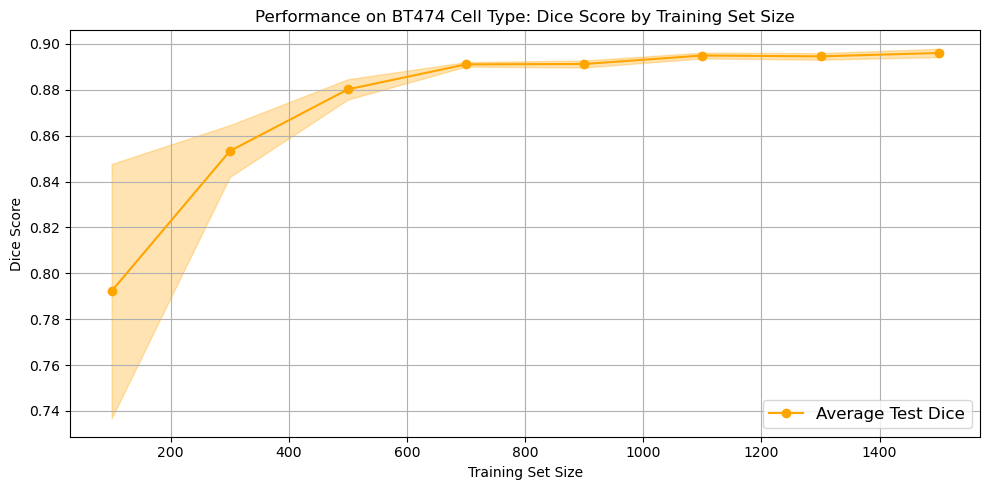

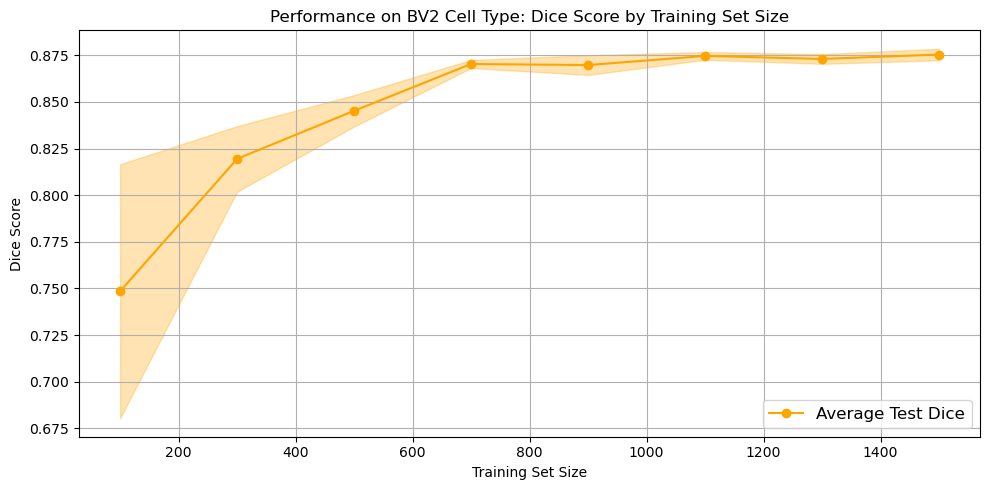

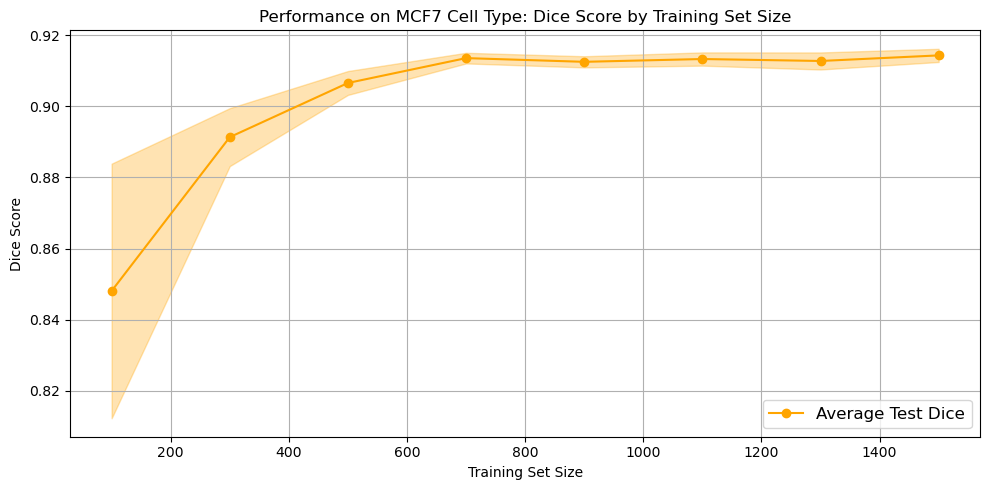

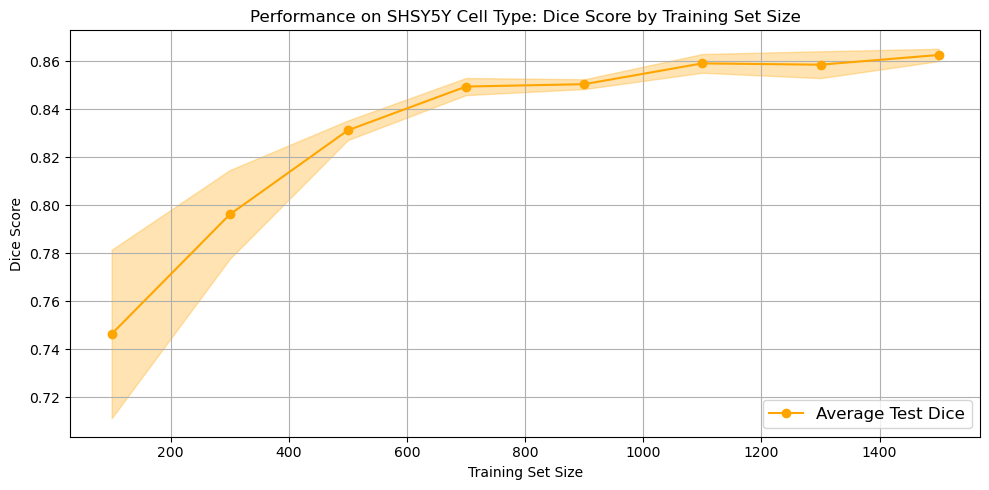

In [25]:
plot_dir = f"../cellTypeDataDensity/{cell_type}"
for cell in cell_types:
    plot_res(cell, test_res[cell], plot_dir)

## Combined plots

Missing file in: .DS_Store


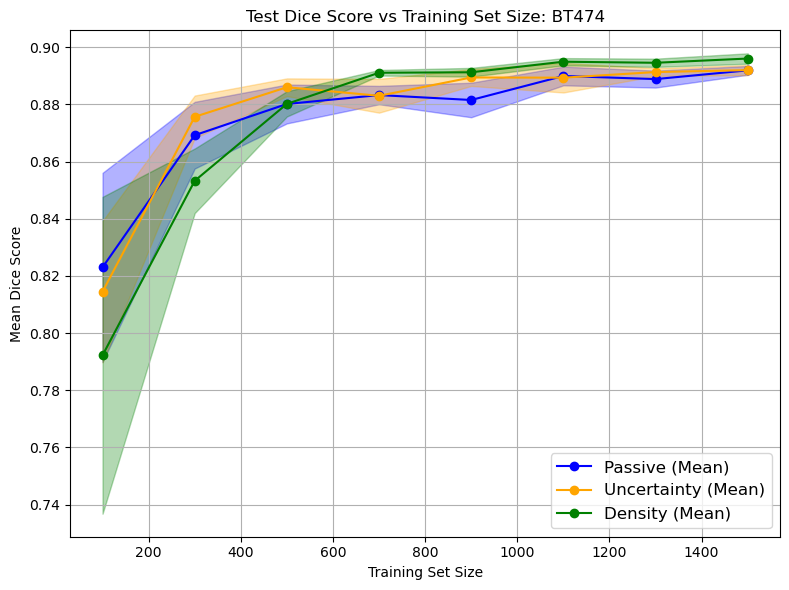

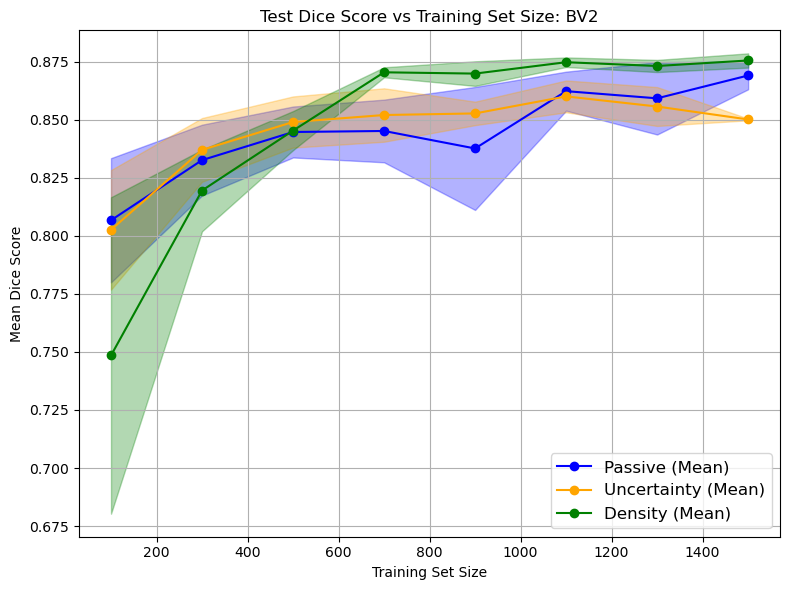

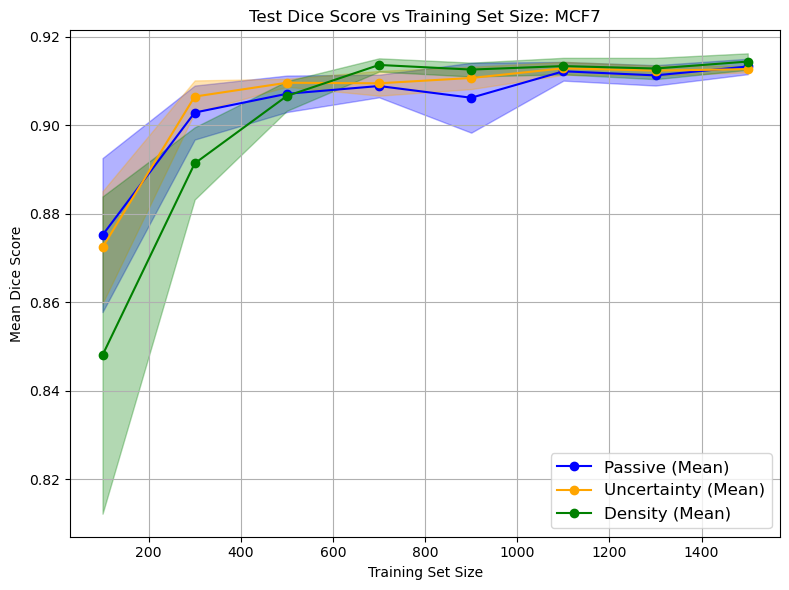

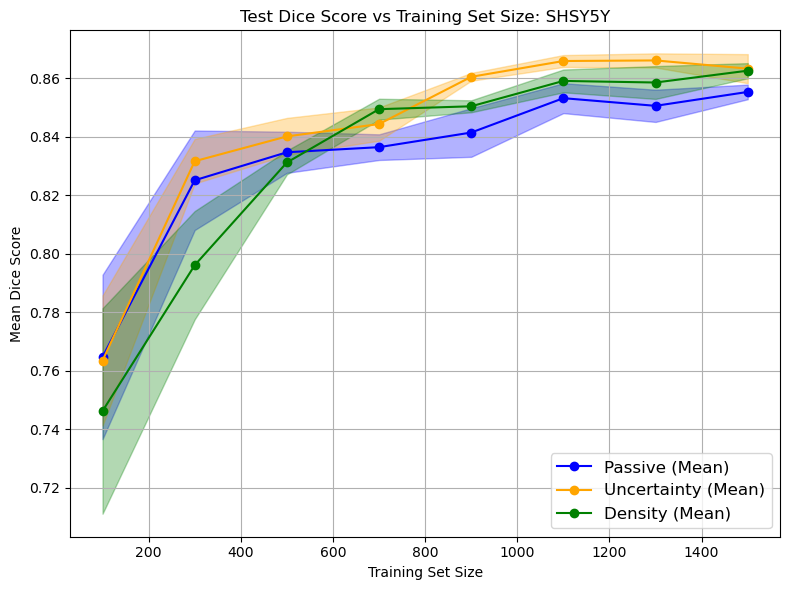

In [29]:
# Combine all three model predictions into one plot and save
folder1 = "../cellTypeData"
folder2 = "../cellTypeDataUncertainty"
folder3 = "../cellTypeDataDensity"
output_dir = "comparison_plots_all_three"
os.makedirs(output_dir, exist_ok=True)

# Common subfolders
subfolders = sorted(os.listdir(folder2))

for sub in subfolders:
    path1 = os.path.join(folder1, sub, "TestDiceScores.csv")
    path2 = os.path.join(folder2, sub, "TestDiceScores.csv")
    path3 = os.path.join(folder3, sub, "TestDiceScores.csv")
    
    if os.path.exists(path1) and os.path.exists(path2) and os.path.exists(path3):
        df1 = pd.read_csv(path1)
        df2 = pd.read_csv(path2)
        df3 = pd.read_csv(path3)

        dataset_size = df1.columns.astype(int)
        means1 = df1.mean()
        stds1 = df1.std()

        means2 = df2.mean()
        stds2 = df2.std()

        means3 = df3.mean()
        stds3 = df3.std()
        
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.plot(dataset_size, means1, label='Passive (Mean)', color='blue', marker='o')
        plt.fill_between(dataset_size, means1 - stds1, means1 + stds1, color='blue', alpha=0.3)

        plt.plot(dataset_size, means2, label='Uncertainty (Mean)', color='orange', marker='o')
        plt.fill_between(dataset_size, means2 - stds2, means2 + stds2, color='orange', alpha=0.3)

        plt.plot(dataset_size, means3, label='Density (Mean)', color='green', marker='o')
        plt.fill_between(dataset_size, means3 - stds3, means3 + stds3, color='green', alpha=0.3)

        plt.title(f"Test Dice Score vs Training Set Size: {sub}")
        plt.xlabel("Training Set Size")
        plt.ylabel("Mean Dice Score")
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True)
        plt.tight_layout()

        out_path = os.path.join(output_dir, f"{sub}_dice_comparison.png")
        plt.savefig(out_path, dpi=300)
        plt.show()
        plt.close()
    else:
        print(f"Missing file in: {sub}")

# Validation set Predictions: Testing on new test set

In [20]:
# Function to get Dice scores for a particular set of objects 
def get_dice_for_set(dataset_loader_object, model_dir):
    test_results = defaultdict(list)
    # Run passive learning loop for inference
    for sim in range(n_simulations):
        for size in sorted(dataset_sizes):
            # Load appropriate model
            model_path = os.path.join(model_dir, f"model_sim{sim}_size{size}.pt")
            model = load_model_from_checkpoint(model_path, device=device)

            dice_scores = []

            with torch.no_grad():
                for img, mask, fname in dataset_loader_object:
                    img, mask = img.to(device), mask.to(device)

                    pred = model(img)
                    pred_bin = (pred > 0.5).float()
                    # Dice score prediction
                    inter = (pred_bin * mask).sum()
                    union = pred_bin.sum() + mask.sum()
                    dice = (2 * inter) / (union + 1e-8)
                    dice_scores.append(dice)

            avg_dice = np.mean(dice_scores)
            test_results[size].append(avg_dice)
            print(f" Avg Dice for sim {sim}, size {size}: {avg_dice:.4f}")
    test_df = pd.DataFrame(test_results)
    return test_df

In [15]:
# Load validation dataset
val_ds =  CellSegmentationDataset("../data/images_val", "../data/masks_val")
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

In [28]:
passive_results = get_dice_for_set(val_loader, "results/passive_learning_partial_training_aws_reproducible/models")

 Avg Dice for sim 0, size 100: 0.7949
 Avg Dice for sim 0, size 300: 0.8636
 Avg Dice for sim 0, size 500: 0.8796
 Avg Dice for sim 0, size 700: 0.8849
 Avg Dice for sim 0, size 900: 0.8920
 Avg Dice for sim 0, size 1100: 0.8963
 Avg Dice for sim 0, size 1300: 0.8919
 Avg Dice for sim 0, size 1500: 0.9027
 Avg Dice for sim 1, size 100: 0.8602
 Avg Dice for sim 1, size 300: 0.8868
 Avg Dice for sim 1, size 500: 0.8946
 Avg Dice for sim 1, size 700: 0.8905
 Avg Dice for sim 1, size 900: 0.8771
 Avg Dice for sim 1, size 1100: 0.9015
 Avg Dice for sim 1, size 1300: 0.8985
 Avg Dice for sim 1, size 1500: 0.8982
 Avg Dice for sim 2, size 100: 0.8390
 Avg Dice for sim 2, size 300: 0.8823
 Avg Dice for sim 2, size 500: 0.8927
 Avg Dice for sim 2, size 700: 0.8877
 Avg Dice for sim 2, size 900: 0.8896
 Avg Dice for sim 2, size 1100: 0.8980
 Avg Dice for sim 2, size 1300: 0.8960
 Avg Dice for sim 2, size 1500: 0.8990
 Avg Dice for sim 3, size 100: 0.8354
 Avg Dice for sim 3, size 300: 0.8861
 Av

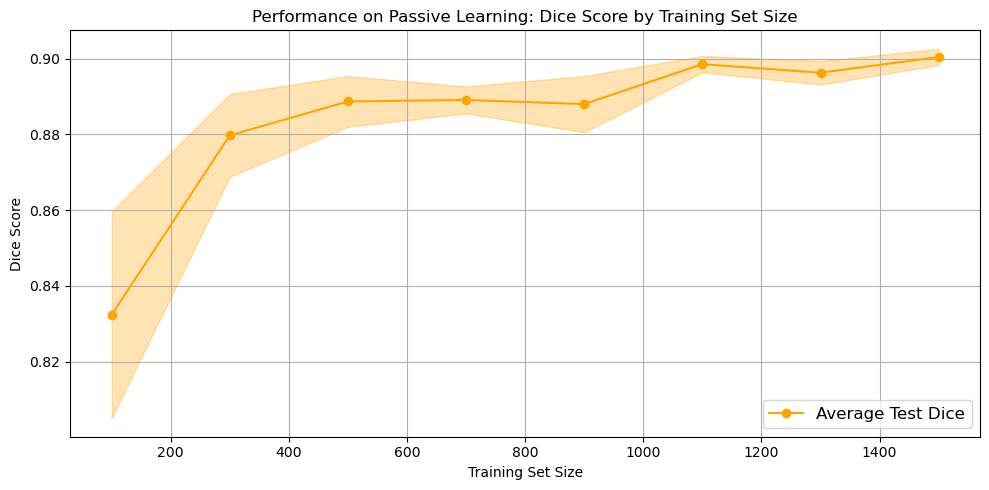

In [33]:
plot_dir = f"../validationSet/passiveLearning"
plot_res('Passive Learning', passive_results, plot_dir)

In [34]:
density_results = get_dice_for_set(val_loader, "results/density_models")

 Avg Dice for sim 0, size 100: 0.7398
 Avg Dice for sim 0, size 300: 0.8493
 Avg Dice for sim 0, size 500: 0.8847
 Avg Dice for sim 0, size 700: 0.9011
 Avg Dice for sim 0, size 900: 0.9012
 Avg Dice for sim 0, size 1100: 0.9053
 Avg Dice for sim 0, size 1300: 0.9027
 Avg Dice for sim 0, size 1500: 0.9082
 Avg Dice for sim 1, size 100: 0.8282
 Avg Dice for sim 1, size 300: 0.8713
 Avg Dice for sim 1, size 500: 0.8904
 Avg Dice for sim 1, size 700: 0.8996
 Avg Dice for sim 1, size 900: 0.9017
 Avg Dice for sim 1, size 1100: 0.9061
 Avg Dice for sim 1, size 1300: 0.9044
 Avg Dice for sim 1, size 1500: 0.9045
 Avg Dice for sim 2, size 100: 0.8428
 Avg Dice for sim 2, size 300: 0.8724
 Avg Dice for sim 2, size 500: 0.8929
 Avg Dice for sim 2, size 700: 0.9000
 Avg Dice for sim 2, size 900: 0.9015
 Avg Dice for sim 2, size 1100: 0.9036
 Avg Dice for sim 2, size 1300: 0.9016
 Avg Dice for sim 2, size 1500: 0.9037
 Avg Dice for sim 3, size 100: 0.8015
 Avg Dice for sim 3, size 300: 0.8619
 Av

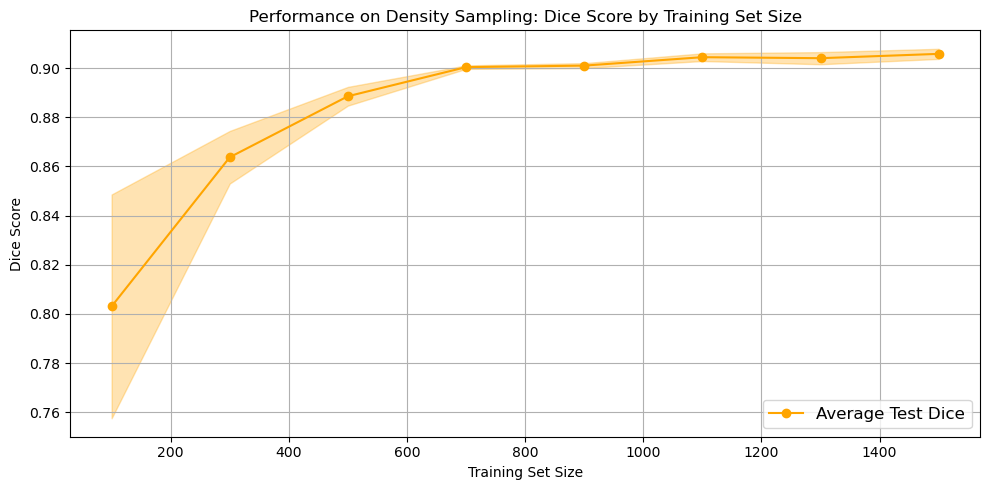

In [35]:
plot_dir = f"../validationSet/densitySampling"
plot_res('Density Sampling', density_results, plot_dir)

In [36]:
uncertainty_results = get_dice_for_set(val_loader, "results/models_uncertainty")

 Avg Dice for sim 0, size 100: 0.8142
 Avg Dice for sim 0, size 300: 0.8849
 Avg Dice for sim 0, size 500: 0.8906
 Avg Dice for sim 0, size 700: 0.8998
 Avg Dice for sim 0, size 900: 0.8984
 Avg Dice for sim 0, size 1100: 0.9016
 Avg Dice for sim 0, size 1300: 0.9009
 Avg Dice for sim 0, size 1500: 0.8979
 Avg Dice for sim 1, size 100: 0.8501
 Avg Dice for sim 1, size 300: 0.8832
 Avg Dice for sim 1, size 500: 0.8901
 Avg Dice for sim 1, size 700: 0.8923
 Avg Dice for sim 1, size 900: 0.8960
 Avg Dice for sim 1, size 1100: 0.9020
 Avg Dice for sim 1, size 1300: 0.8995
 Avg Dice for sim 1, size 1500: 0.9006
 Avg Dice for sim 2, size 100: 0.8508
 Avg Dice for sim 2, size 300: 0.8824
 Avg Dice for sim 2, size 500: 0.8945
 Avg Dice for sim 2, size 700: 0.8951
 Avg Dice for sim 2, size 900: 0.9007
 Avg Dice for sim 2, size 1100: 0.9027
 Avg Dice for sim 2, size 1300: 0.9009
 Avg Dice for sim 2, size 1500: 0.9006
 Avg Dice for sim 3, size 100: 0.8142
 Avg Dice for sim 3, size 300: 0.8804
 Av

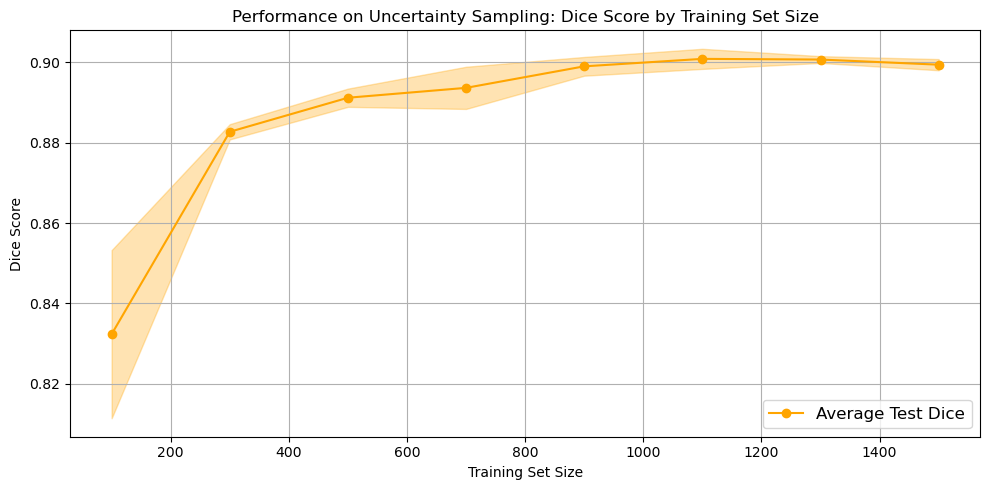

In [37]:
plot_dir = f"../validationSet/uncertaintySampling"
plot_res('Uncertainty Sampling', uncertainty_results, plot_dir)